# Persoalan
Unduhlah salah satu data di situs SEKI https://www.bi.go.id/id/statistik/ekonomi-
keuangan/seki/default.aspx , Lakukan  prediktif analitik, time series forecasting untuk 
menganalisis ada tidaknya tren, siklus atau seasonal. Berikan penjelasan hasil perhitungan 
dan carilah perhitungan performanya.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [107]:
# 1. Load Dataset
df = pd.read_excel('../dataset/TABEL7_1_revisi.xlsx', sheet_name='Sheet3')
df = df.rename(columns={'PRODUK DOMESTIK BRUTO': 'PDB'})
df['Quarter'] = pd.to_datetime(df['Quarter'], errors='coerce')
df = df.set_index('Quarter')

In [108]:
# 2. Data Preprocessing
# Mengisi nilai hilang
df['PDB'] = df['PDB'].interpolate(method='time')

# Standardisasi data
scaler = StandardScaler()
df['PDB_scaled'] = scaler.fit_transform(df[['PDB']])

# Uji stasioneritas dan differencing
adf_test = adfuller(df['PDB_scaled'])
if adf_test[1] > 0.05:
    df['PDB_diff'] = df['PDB_scaled'].diff().dropna()
    data_for_model = df['PDB_diff']
else:
    data_for_model = df['PDB_scaled']

data_for_model = data_for_model.dropna()

In [109]:
# 3. Split Data untuk Training dan Testing
train = data_for_model.iloc[:-12]
test = data_for_model.iloc[-12:]


In [110]:
# 4. Training Model SARIMA
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
sarima_model = model.fit()


/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42862D-01    |proj g|=  5.98677D-01

At iterate    5    f=  7.03741D-01    |proj g|=  1.57383D-01

At iterate   10    f=  6.22899D-01    |proj g|=  8.39575D-03

At iterate   15    f=  6.13615D-01    |proj g|=  1.31285D-02

At iterate   20    f=  6.13054D-01    |proj g|=  1.99779D-02

At iterate   25    f=  6.12972D-01    |proj g|=  8.40026D-04

At iterate   30    f=  6.12963D-01    |proj g|=  3.52814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

MAE: 197346.05889651002
MSE: 65939942655.25543
RMSE: 256787.73852202413


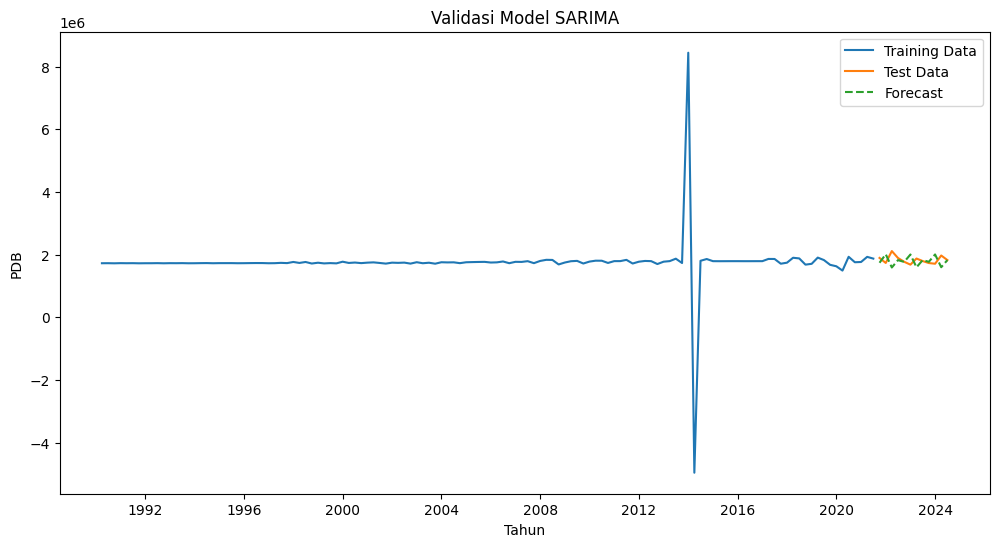

In [112]:
# 5. Validation
forecast = sarima_model.forecast(steps=len(test))
forecast_array = np.array(forecast).reshape(-1, 1)  # Konversi ke array dan reshape
forecast_original = scaler.inverse_transform(forecast_array).flatten()

test_array = np.array(test).reshape(-1, 1)  # Konversi data uji ke array
test_original = scaler.inverse_transform(test_array).flatten()

mae = mean_absolute_error(test_original, forecast_original)
mse = mean_squared_error(test_original, forecast_original)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Plot hasil validasi
plt.figure(figsize=(12, 6))
plt.plot(train.index, scaler.inverse_transform(train.values.reshape(-1, 1)), label="Training Data")
plt.plot(test.index, test_original, label="Test Data")
plt.plot(test.index, forecast_original, label="Forecast", linestyle='--')
plt.title("Validasi Model SARIMA")
plt.xlabel("Tahun")
plt.ylabel("PDB")
plt.legend()
plt.show()


In [113]:
# 6. Projection
future_steps = 24  # Proyeksi 24 kuartal ke depan (6 tahun)
forecast_future = sarima_model.forecast(steps=future_steps)
forecast_future_original = scaler.inverse_transform(forecast_future.reshape(-1, 1)).flatten()

future_dates = pd.date_range(start=test.index[-1], periods=future_steps + 1, freq='Q')[1:]
projection_df = pd.DataFrame({"Quarter": future_dates, "Forecasted_PDB": forecast_future_original})

# Plot hasil proyeksi
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PDB'], label="Data Aktual")
plt.plot(projection_df['Quarter'], projection_df['Forecasted_PDB'], label="Proyeksi", linestyle='--')
plt.title("Proyeksi PDB Masa Depan")
plt.xlabel("Tahun")
plt.ylabel("PDB")
plt.legend()
plt.show()

# Menampilkan Proyeksi
print("Proyeksi PDB Masa Depan:")
print(projection_df)

AttributeError: 'Series' object has no attribute 'reshape'